 
# Netplotbrain with network based statistics

[Open interactive notebook in Binder](https://mybinder.org/v2/gh/wiheto/netplotbrain/main?filepath=docs/gallery/nbs.ipynb)

## Plotting significant results from network based statistics
Netplotbrain aims to try and integrate with other tools, minimizing the work needed.
For this we are going to use bctpy's implementation of network based statistics.

In [1]:
import bct
import numpy as np
import matplotlib.pyplot as plt
import netplotbrain

### Generating the data

To run NBS statistics we need connectivity matrices for multiple subjects.
The data we will need is a N x N x S array for two separate groups, where N is the number of nodes and S is the number of subjects.

In this subsection we will create dummy data to simulate the point. Skip to the next subsection if you just want to see how netplotbrain integrates with NBS statistics.

We are going to create connectivity matrices with 100 nodes for 50 subjects.
The 100 nodes will be split into 6 communities of varying sizes.
Edge weights will be sampled from a normal distribution with the standard deviation set to 0.25.
The mean of the normal distribution for each edge varies.
For between-community edges the mean is set to 0. For within community edges each community is set to a different value. This value will differ between the two groups.

In [2]:
def generate_group_cm(nodes, subjects, community_size, community_str, scale=0.25, seed=2022):
    """
    Quick way to simulate group differences for visualization purposes.

    Input
    -----
    nodes : int
        number of nodes
    subjects : int
        number of subjects
    community_size : list
        list of number of nodes in each community
    community_str : list
        list of mean str for within community connections
    scale : float
        scale (STD) of normal distribution.
    """
    np.random.seed(seed)
    mu = np.zeros([nodes, nodes, 1])
    np.fill_diagonal(mu[:, :, 0], 1)
    ci = 0
    for i, c in enumerate(community_size):
        mu[ci:ci+c, ci:ci+c, :] = community_str[i]
        ci += c

    # Simulate data
    g = np.random.normal(mu, scale, size=[nodes, nodes, subjects])
    # Force to be symmetric
    ind_i, ind_j = np.triu_indices(g.shape[0], k=1)
    g[ind_j, ind_i] = g[ind_i, ind_j]
    return g

# Specify variable for generating data
nodes = 100
subjects_per_group = 50
community_size = [13, 7, 35, 15, 20, 5]

g1_community_str = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
g2_community_str = [0.17, 0.7, 0.13, 0.1, 0.15, 0.6]

g1 = generate_group_cm(nodes, subjects_per_group, community_size, g1_community_str)
g2 = generate_group_cm(nodes, subjects_per_group, community_size, g2_community_str)

## Running NBS statistics

From the generated data.
Using the NBS implementation from bctpy with generate the p values

In [3]:
# g1 and g2 are both (Node, Node, Subject) in size.
# The third input argument is the cluster threshold (set far too high here, but to ensure we just get the 2 extreme communities).
# Note, k=100 is set for speed purposes. Should be larger.  
p, adj, null = bct.nbs_bct(g1, g2, 4, k=100, seed=2022)

max component size is 21
estimating null distribution with 100 permutations
permutation 0 of 100.  p-value so far is 0.000
permutation 10 of 100.  p-value so far is 0.000
permutation 20 of 100.  p-value so far is 0.000
permutation 30 of 100.  p-value so far is 0.000
permutation 40 of 100.  p-value so far is 0.000
permutation 50 of 100.  p-value so far is 0.000
permutation 60 of 100.  p-value so far is 0.000
permutation 70 of 100.  p-value so far is 0.000
permutation 80 of 100.  p-value so far is 0.000
permutation 90 of 100.  p-value so far is 0.000
permutation 99 of 100.  p-value so far is 0.000


Let us now visualize the data we have created.
Here we see the correlation matrices and the 2 significant clusters created.

Text(0.5, 1.0, 'Significant Clusters')

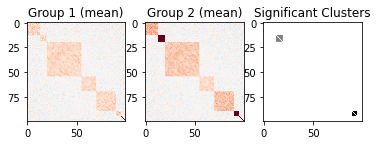

In [4]:
fig, ax = plt.subplots(1, 3)
ax[0].imshow(np.mean(g1, axis=-1), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[0].set_title('Group 1 (mean)')
ax[1].imshow(np.mean(g2, axis=-1), cmap='RdBu_r', vmin=-0.5, vmax=0.5)
ax[1].set_title('Group 2 (mean)')
ax[2].imshow(adj, cmap='binary')
ax[2].set_title('Significant Clusters')

### Plotting in netplotbrain

We will assume that are 100 random nodes correspond to the Schaefer 2018 atlas with 100 parcels.
With this information, we can call netplotbrain.

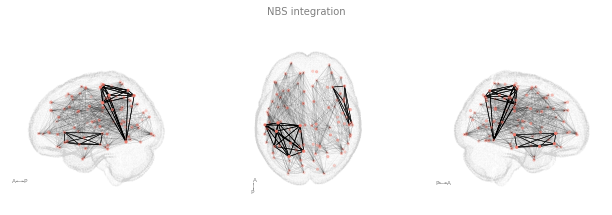

In [5]:
# For out edges let's plot the group different.
gdif = np.mean(g2,axis=-1) - np.mean(g1,axis=-1)

fig, ax = netplotbrain.plot(template='MNI152NLin2009cAsym',
                            nodes={'atlas': 'Schaefer2018',
                                     'desc': '100Parcels7Networks',
                                     'resolution': 1},
                            edges=gdif,
                            highlight_edges=adj,
                            template_style='glass',
                            view=['LSR'],
                            title='NBS integration',
                            node_type='circles',
                            highlight_level=0.5)

The amount of highlight is governed by the highlight_level argument.
Increasing it highlights the significant edges more.